In [890]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Idea:
Our model is represented as
$$X_t= P^{-1}APX_{t-1}+W_t,$$
Where $W_t$ are i.i.d. normal (to keep things simply let’s say $\mathcal{N}(0,I)$), and $A$ is lower triangular. 

In [891]:
def generate_data_nD(length, n, A, P):
    
    # initialize series
    series = np.array(np.zeros((length, n)))
    
    # get inverse
    inv_P = np.linalg.inv(P)
    
    # generate series
    for t in range(1, length):
        # generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), np.identity(n)))
    
    return series

Furthermore, let’s assume $P$ is sampled from a uniform distribution over the set of possible permutations $\mathcal{P}$. Note that the size of this set is $n!$Given this model, the likelihood of the observations is

$$L(A)=\sum_{p\in\mathcal{P}} \frac{1}{|\mathcal{P}|} L(A,P) = \exp(l(A,P)),$$
where $l(A, P)$ is the complete log-likelihood. Our goal is to find the lower-triangular matrix $A$ that maximizes $L(A)$ (note this is not the original problem we set to solve). At this point we are “primed” to use the EM algorithm. Let $i$ be the iterations. Let’s start with the $E$-step. Compute the “weight” associated with each permutation matrix:
$$W_i^P=\exp(-1/2\sum_t \|X_t-P^{-1}A_i P X_{t-1}\|^2).$$

In [895]:
def W(A, P):
    
    P_inv = np.linalg.inv(P)
    
    weight = 0

    for t in range(1, length):
        weight += np.linalg.norm(series[t] - np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))) ** 2
    
    return np.exp(-weight / 2)

def get_W(A):
    weights = []
    for perm in permutations(np.identity(n)):
        weights.append(W(A, perm))
    return weights / np.sum(weights)

This $M$-step finds $A_{i+1}$ by maximizing $h(A)$. Note this is a quadratic function of the elements of $A$.
$$h(A)=-\sum_{p\in\mathcal{P}} W_i^{P}\sum_t \|X_t-P^{-1}AP X_{t-1}\|^2$$

In [896]:
def h(A_inp):
    h_value = 0
    
    weights = get_W(A)

    i = 0
    
    for perm in permutations(np.identity(n)):
        
        w = weights[i]
        i += 1
        
        perm_inv = np.linalg.inv(perm)
        
        for t in range(1, length):
            h_value -= w * np.linalg.norm(series[t] - np.matmul(perm_inv, np.matmul(A_inp, np.matmul(perm, series[t - 1])))) ** 2
            
    return h_value

[[0.36813037 0.         0.        ]
 [0.06178308 0.35945047 0.        ]
 [0.56040181 0.08253628 0.9290188 ]] (array([0., 1., 0.]), array([0., 0., 1.]), array([1., 0., 0.]))


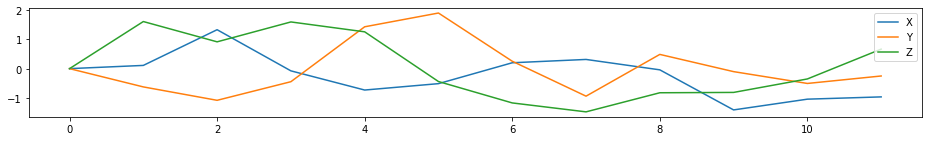

In [928]:
#np.random.seed(seed = 123)

length, n = 12, 3

# A matrix, lower triangular
# A = np.array([[0.8, 0, 0], [0.4, 0.4, 0], [0.3, 0.3, 0.3]])
A = np.tril(np.random.rand(n, n))

# Permutation matrix
P = np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
# P = np.identity(n)
r_ind = np.random.choice(np.math.factorial(n))
P = list(permutations(np.identity(n)))[r_ind]

# Generate nD data
series = generate_data_nD(length, n, A, P)

print(A, P)
# Plot
plt.figure(figsize=(16,2))
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

In [930]:
A_plot = np.tril(np.random.rand(n, n))

In [934]:
# for i in range(n - 1, -1, -1):
#     for j in range(0, i + 1, 1):
for i in range(n):
    for j in range(i + 1):
        a_list = np.linspace(-1, 2, 200)
        results = []

        for a in a_list:
            A_plot[i][j] = a
            results.append(h(A_plot))
        A_plot[i][j] = a_list[np.argmax(results)]
        print(np.argmax(results), a_list[np.argmax(results)])

103 0.5527638190954773
66 -0.005025125628140725
101 0.5226130653266332
78 0.1758793969849246
62 -0.0653266331658292
102 0.5376884422110553


In [935]:
print(f"A:\n{np.round(A, 2)}\n\nA_hat:\n{np.round(A_plot, 2)}\n")
print(f"Weights: {np.round(get_W(A_plot), 2)}")
print(f"P:\t{P}")
print(f"P_hat:\t{list(permutations(np.identity(n)))[np.argmax(get_W(A_plot))]}")

A:
[[0.37 0.   0.  ]
 [0.06 0.36 0.  ]
 [0.56 0.08 0.93]]

A_hat:
[[ 0.55  0.    0.  ]
 [-0.01  0.52  0.  ]
 [ 0.18 -0.07  0.54]]

Weights: [0.27 0.12 0.04 0.14 0.26 0.16]
P:	(array([0., 1., 0.]), array([0., 0., 1.]), array([1., 0., 0.]))
P_hat:	(array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.]))


In [936]:
from itertools import permutations

perms = permutations(np.identity(n))

i = 0

for perm in perms:
    i += 1
    perm_inv = np.linalg.inv(perm)
    cost = 0
    for t in range(1, length):
        cost += np.linalg.norm(series[t] - np.matmul(perm_inv, np.matmul(A_plot, np.matmul(perm, series[t - 1])))) ** 2
    print(cost / (length - 1))

1.8282164663602485
1.9847158300466108
2.159634161547809
1.9464323100993584
1.8350732273669588
1.9228056897435908


In [394]:
print(W(A_plot, P))

2.1033027681109898e-67
